## MERA
MERA structure TN for machine learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.enable_v2_behavior
# Import tensornetwork
import tensornetwork as tn
# Set the backend to tesorflow
# (default is numpy)
tn.set_default_backend("tensorflow")

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data("/hpc/group/carin/fk43/FanjieKong/Megapixels/new_tfquantum/quantum/TensorNetwork/mnist.npz")

In [3]:
from tensorflow.keras.utils import to_categorical

x_train = x_train.reshape((60000, 28, 28, 1)).astype(np.float32)
y_train = to_categorical(y_train, 10).astype(np.float32)
x_test = x_test.reshape((10000, 28, 28, 1))
y_test = to_categorical(y_test, 10)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(y_train)

(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


(-0.5, 27.5, 27.5, -0.5)

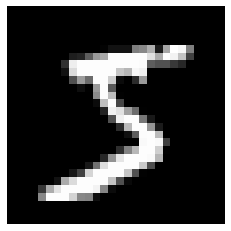

In [6]:
plt.imshow(x_train[0], cmap='gray')
plt.axis('off')

In [4]:
xx_train = tf.image.resize(x_train, [8,8])
xx_test = tf.image.resize(x_test, [8,8])


In [5]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

[]

In [6]:
class TNLayer(tf.keras.layers.Layer):
    
    def __init__(self, dim):
        super(TNLayer, self).__init__()
        # Create the variables for the layer.
        self.dim = dim
        self.a_var = tf.Variable(tf.random.normal(shape=(dim, dim, 2), stddev=1.0/dim), name="a", trainable=True)
        self.b_var = tf.Variable(tf.random.normal(shape=(dim, dim, 2), stddev=1.0/dim), name="b", trainable=True)
        self.bias = tf.Variable(tf.zeros(shape=(dim, dim)), name="bias", trainable=True)

    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        print(inputs.shape)
        def f(input_vec, a_var, b_var, bias_var):
            # Reshape to a matrix instead of a vector.
            input_vec = tf.reshape(input_vec, (self.dim, self.dim))

            # Now we create the network.
            a = tn.Node(a_var)
            b = tn.Node(b_var)
            x_node = tn.Node(input_vec)
            a[1] ^ x_node[0] # ^ means connection
            b[1] ^ x_node[1]
            a[2] ^ b[2]

            # The TN should now look like this
            #   |     |
            #   a --- b
            #    \   /
            #      x

            # Now we begin the contraction.
            c = a @ x_node
            result = (c @ b).tensor

            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        result = tf.vectorized_map(lambda vec: f(vec, self.a_var, self.b_var, self.bias), inputs)
        return tf.nn.relu(tf.reshape(result, (-1, self.dim**2)))

In [28]:
class MERA(tf.keras.layers.Layer):
    
    def __init__(self, dim):
        super(TNLayer, self).__init__()
        # Create the variables for the layer.
        self.dim = dim
        self.a_var = tf.Variable(tf.random.normal(shape=(dim, dim, 2), stddev=1.0/dim), name="a", trainable=True)
        self.b_var = tf.Variable(tf.random.normal(shape=(dim, dim, 2), stddev=1.0/dim), name="b", trainable=True)
        self.bias = tf.Variable(tf.zeros(shape=(dim, dim)), name="bias", trainable=True)

    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        print(inputs.shape)
        def f(input_vec, a_var, b_var, bias_var):
            # Reshape to a matrix instead of a vector.
            input_vec = tf.reshape(input_vec, (self.dim, self.dim))

            # Now we create the network.
            a = tn.Node(a_var)
            b = tn.Node(b_var)
            x_node = tn.Node(input_vec)
            a[1] ^ x_node[0] # ^ means connection
            b[1] ^ x_node[1]
            a[2] ^ b[2]

            # The TN should now look like this
            #   |     |
            #   a --- b
            #    \   /
            #      x

            # Now we begin the contraction.
            c = a @ x_node
            result = (c @ b).tensor

            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        result = tf.vectorized_map(lambda vec: f(vec, self.a_var, self.b_var, self.bias), inputs)
        return tf.nn.relu(tf.reshape(result, (-1, self.dim**2)))

In [30]:
class MERA(tf.keras.layers.Layer):
    
    def __init__(self, dim, n_nodes):
        super(MERA, self).__init__()
        # Create the variables for the layer.
        # In this case, the input tensor is (, 1936), we factorize it into a tensor (, 11, 11, 16)
        # first_dim: output shape?
        # second_dim: connect with data tensor
        # third_dim: inter-connect
        self.dim = dim
        self.a_var = tf.Variable(tf.random.normal(shape=(11, 11), stddev=1.0/dim), name="a", trainable=True)
        self.b_var = tf.Variable(tf.random.normal(shape=(11, 11, 11), stddev=1.0/dim), name="b", trainable=True)
        self.c_var = tf.Variable(tf.random.normal(shape=(16, 16), stddev=1.0/dim), name="b", trainable=True)
        
        self.d_var = tf.Variable(tf.random.normal(shape=(11, 11, 10), stddev=1.0/dim), name="b", trainable=True)
        self.e_var = tf.Variable(tf.random.normal(shape=(11, 16, 10), stddev=1.0/dim), name="b", trainable=True)
        self.f_var = tf.Variable(tf.random.normal(shape=(10, 10, 10), stddev=1.0/dim), name="b", trainable=True)

        self.bias = tf.Variable(tf.zeros(shape=(10)), name="bias", trainable=True)

    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, a_var, b_var, c_var, d_var, e_var, f_var, bias_var):
            # Reshape to a matrix instead of a vector.
            print(input_vec)
            input_vec = tf.reshape(input_vec, (11, 11, 16))
        
            # Now we create the network.
            a = tn.Node(a_var)
            b = tn.Node(b_var)
            c = tn.Node(c_var)
            d = tn.Node(d_var)
            e = tn.Node(e_var)
            f = tn.Node(f_var)
            
            x_node = tn.Node(input_vec)
            a[0] ^ x_node[0]
            b[0] ^ x_node[1]
            c[0] ^ x_node[2]
            a[1] ^ d[0]
            b[1] ^ d[1]
            b[2] ^ e[0]
            c[1] ^ e[1]
            d[2] ^ f[0]
            e[2] ^ f[1]
            

            # The TN should now look like this
            #          |
            #          f
            #       /    \
            #     d       e
            #   /    \ /    \
            #   a     b     c
            #    \   |     /
            #        x

            # Now we begin the contraction.
            # c1 = a @ x_node # avoid trace edge?
            # c2 = c1 @ b
            #c1 = a @ x_node
            #c2 = c1 @ b
            #c3 = c2 @ c
            #result = c3.tensor
            nodes = tn.reachable(f)
            result = tn.contractors.greedy(nodes)
            result = result.tensor
            #print(result)
            
            #result = (c @ b).tensor

            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        result = tf.vectorized_map(lambda vec: f(vec, self.a_var, self.b_var, self.c_var, 
                                                 self.d_var, self.e_var, self.f_var, self.bias), inputs)
        return tf.nn.relu(tf.reshape(result, (-1, 10)))

In [8]:
 tf.image.extract_patches(images=tf.ones((5, 28, 28, 1)),
                           sizes=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

<tf.Tensor: shape=(5, 14, 14, 4), dtype=float32, numpy=
array([[[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        ...,

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1.,

In [9]:
tf.ones((5, 28, 28, 1)).shape[0]

5

In [28]:
for e_ones in tf.ones((5, 28, 28, 1)):
    print(tf.sin(e_ones[0,0,:]).shape)

(1,)
(1,)
(1,)
(1,)
(1,)


In [11]:
np.log2(28)

4.807354922057604

In [31]:
a = [tn.Node([1,1])]

In [49]:
test = []
for i in range(7):
    for ii in range(7):
        test.append(0+ 28 * i+2*ii)
        test.append(1+ 28 * i+2*ii)
        test.append(14+ 28 * i+2*ii)
        test.append(15+ 28 * i+2*ii)

In [84]:
len(test)

196

In [26]:
tf.compat.v1.enable_eager_execution()
class twoDtreeMERA(tf.keras.layers.Layer):
    def __init__(self, input_dim, bond_dims, output_dims, n_layers=None):
        super(twoDtreeMERA, self).__init__()
        # Create the variables for the layer.
        # In this case, the input tensor is (, 1936), we factorize it into a tensor (, 11, 11, 16)
        # first_dim: output shape?
        # second_dim: connect with data tensor
        # third_dim: inter-connect
        if n_layers is None:
            n_layers = np.floor(np.log2(input_dim))
        self.n_layers = n_layers
        in_dims = 2
        dims = input_dim
        self.entanglers = []
        self.isometries= []
        for i in range(n_layers):
            if dims % 2 == 0:
                dims = int(dims//2)
                self.entanglers.append([tf.Variable(tf.random.normal
                                             (shape=(in_dims, in_dims, 
                                                     in_dims, in_dims, bond_dims, bond_dims, bond_dims, bond_dims),
                                              stddev=1.0/bond_dims), 
                                              trainable=True) for j in range(dims**2)])
                in_dims = bond_dims
                self.isometries.append([tf.Variable(tf.random.normal(shape=(bond_dims, bond_dims, bond_dims, 
                                                                            bond_dims, bond_dims)
                                                                     , stddev=1.0/bond_dims),
                                            trainable=True) for j in range(dims**2)])
#             else:
#                 # odd number layer
#                 dims = int(dims//2)
#                 self.entanglers.append([tf.Variable(tf.random.normal
#                                              (shape=(in_dims, in_dims, 
#                                                      in_dims, in_dims, bond_dims, bond_dims, bond_dims, bond_dims),
#                                               stddev=1.0/bond_dims), 
#                                               trainable=True) for j in range(dims**2)]+[tf.Variable(tf.random.normal
#                                              (shape=(in_dims, in_dims, 
#                                                      in_dims, in_dims, bond_dims, bond_dims, bond_dims, bond_dims),
#                                               stddev=1.0/bond_dims), 
#                                               trainable=True)])
                
                
                
        self.final_mps = tf.Variable(tf.random.normal(shape=(bond_dims,)*(dims**2) + (output_dims,)
                                                                 , stddev=1.0/output_dims))

        
        self.bias = tf.Variable(tf.zeros(shape=(output_dims)), name="bias", trainable=True)

    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, entanglers, isometries, final_mps, bias_var, n_layers):
            # Reshape to a matrix instead of a vector.
            #print(input_vec)
            patches = tf.image.extract_patches(images=tf.reshape(input_vec, 
                                                       (1, input_vec.shape[0],  input_vec.shape[1],  input_vec.shape[2])),
                           sizes=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')
            # (1, 14, 14, 4)
            # Z trace permute the input patches?
            patches = tf.reshape(patches, (patches.shape[1]*patches.shape[2], patches.shape[3]))
            # (196, 4)
            #print(patches)
            patches = tf.unstack(patches)
            input_patches = [tf.concat([tf.expand_dims(tf.sin(e_patch), axis=1),
                                                 tf.expand_dims(tf.cos(e_patch), axis=1)], axis=1) for e_patch in patches]

#             for e_patch in patches:
#                 input_patches.append(tf.expand_dims(tf.concat([tf.expand_dims(tf.sin(e_patch), axis=1),
#                                                 tf.expand_dims(tf.cos(e_patch), axis=1)], axis=1), axis=0))
                
#             input_patches = tf.concat(input_patches, axis=0)
            # create nodes
            input_nodes_list = []
            for e_ip in input_patches:
                input_nodes_list.append([tn.Node(e_ip[0, :]),
                tn.Node(e_ip[1, :]),
                tn.Node(e_ip[2, :]),
                tn.Node(e_ip[3, :])])
            
            entangler_nodes_list = []
            for layer in range(self.n_layers):
                entangler_nodes_list_in_one_layer = []
                for idx, e_e in enumerate(entanglers[layer]):
                    entangler_nodes_list_in_one_layer.append(tn.Node(e_e))
                entangler_nodes_list.append(entangler_nodes_list_in_one_layer)
                                     
            isometries_nodes_list = []
            for layer in range(self.n_layers):
                isometries_nodes_list_in_one_layer = []
                for idx, e_i in enumerate(isometries[layer]):
                    isometries_nodes_list_in_one_layer.append(tn.Node(e_i))
                isometries_nodes_list.append(isometries_nodes_list_in_one_layer)
            
            mps_node = tn.Node(final_mps)
            #connect nodes           
            for i in range(len(entangler_nodes_list[0])):                 
                input_nodes_list[i][0][0] ^ entangler_nodes_list[0][i][0]
                input_nodes_list[i][1][0] ^ entangler_nodes_list[0][i][1]
                input_nodes_list[i][2][0] ^ entangler_nodes_list[0][i][2]
                input_nodes_list[i][3][0] ^ entangler_nodes_list[0][i][3]

                isometries_nodes_list[0][i][0] ^ entangler_nodes_list[0][i][4]
                isometries_nodes_list[0][i][1] ^ entangler_nodes_list[0][i][5]
                isometries_nodes_list[0][i][2] ^ entangler_nodes_list[0][i][6]
                isometries_nodes_list[0][i][3] ^ entangler_nodes_list[0][i][7]
            #re-permute iso list to keep spatial coordinates
            #print(len(isometries_nodes_list[0]))
            new_iso_nodes_list = []
            for i in range(6):
                for ii in range(6):
                    new_iso_nodes_list.append(isometries_nodes_list[0][0+ 24 * i+2*ii])
                    new_iso_nodes_list.append(isometries_nodes_list[0][1+ 24 * i+2*ii])
                    new_iso_nodes_list.append(isometries_nodes_list[0][12+ 24 * i+2*ii])
                    new_iso_nodes_list.append(isometries_nodes_list[0][13+ 24 * i+2*ii])
            #print(len(new_iso_nodes_list))
            isometries_nodes_list[0] = new_iso_nodes_list
            ###
            #print(len(isometries_nodes_list[0]))
            #print(len(entangler_nodes_list[1]))
            for i in range(len(entangler_nodes_list[1])):                 
                isometries_nodes_list[0][i*4+0][4] ^ entangler_nodes_list[1][i][0]
                isometries_nodes_list[0][i*4+1][4] ^ entangler_nodes_list[1][i][1]
                isometries_nodes_list[0][i*4+2][4] ^ entangler_nodes_list[1][i][2]
                isometries_nodes_list[0][i*4+3][4] ^ entangler_nodes_list[1][i][3]
                
                isometries_nodes_list[1][i][0] ^ entangler_nodes_list[1][i][4]        
                isometries_nodes_list[1][i][1] ^ entangler_nodes_list[1][i][5]        
                isometries_nodes_list[1][i][2] ^ entangler_nodes_list[1][i][6]        
                isometries_nodes_list[1][i][3] ^ entangler_nodes_list[1][i][7]        
            
            new_iso_nodes_list = []
            for i in range(3):
                for ii in range(3):
                    new_iso_nodes_list.append(isometries_nodes_list[1][0+ 12 * i+2*ii])
                    new_iso_nodes_list.append(isometries_nodes_list[1][1+ 12 * i+2*ii])
                    new_iso_nodes_list.append(isometries_nodes_list[1][6+ 12 * i+2*ii])
                    new_iso_nodes_list.append(isometries_nodes_list[1][7+ 12 * i+2*ii])
            isometries_nodes_list[1] = new_iso_nodes_list
            
            for i in range(len(entangler_nodes_list[2])):                 
                isometries_nodes_list[1][i*4+0][4] ^ entangler_nodes_list[2][i][0]
                isometries_nodes_list[1][i*4+1][4] ^ entangler_nodes_list[2][i][1]
                isometries_nodes_list[1][i*4+2][4] ^ entangler_nodes_list[2][i][2]
                isometries_nodes_list[1][i*4+3][4] ^ entangler_nodes_list[2][i][3]
                
                isometries_nodes_list[2][i][0] ^ entangler_nodes_list[2][i][4]        
                isometries_nodes_list[2][i][1] ^ entangler_nodes_list[2][i][5]        
                isometries_nodes_list[2][i][2] ^ entangler_nodes_list[2][i][6]        
                isometries_nodes_list[2][i][3] ^ entangler_nodes_list[2][i][7] 
                
            
                isometries_nodes_list[2][i][4] ^ mps_node[i] 
            # final mps connection
                                                 

            # The TN should now look like this
            #          |
            #          f
            #       /    \
            #     d       e
            #   /    \ /    \
            #   a     b     c
            #    \   |     /
            #        x

            # Now we begin the contraction.
            # c1 = a @ x_node # avoid trace edge?
            # c2 = c1 @ b
            #c1 = a @ x_node
            #c2 = c1 @ b
            #c3 = c2 @ c
            #result = c3.tensor
            nodes = tn.reachable(mps_node)
            result = tn.contractors.greedy(nodes)
            result = result.tensor
            #print(result)
            #result = (c @ b).tensor
            # Finally, add bias.
            return result + bias_var
        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        result = tf.vectorized_map(lambda vec: f(vec, self.entanglers, 
                                                 self.isometries, self.final_mps, self.bias, self.n_layers), inputs)
        return tf.nn.relu(tf.reshape(result, (-1, 10)))

In [80]:
class MERA(tf.keras.layers.Layer):
    
    def __init__(self, input_dim, bond_dims, output_dims, n_layers=None):
        super(MERA, self).__init__()
        # Create the variables for the layer.
        # In this case, the input tensor is (, 1936), we factorize it into a tensor (, 11, 11, 16)
        # first_dim: output shape?
        # second_dim: connect with data tensor
        # third_dim: inter-connect
        if n_layers is None:
            n_layers = np.floor(np.log2(input_dim))
        self.n_layers = n_layers
        in_dims = 2
        dims = input_dim
        self.entanglers = []
        self.isometries= []
        for i in range(n_layers):
            if dims % 2 == 0:
                dims = int(dims//2)
                self.entanglers.append([tf.Variable(tf.random.normal
                                             (shape=(in_dims, in_dims, 
                                                     in_dims, in_dims, bond_dims, bond_dims, bond_dims, bond_dims),
                                              stddev=1.0/bond_dims), 
                                              trainable=True) for j in range(dims**2)])
                in_dims = bond_dims
                self.isometries.append([tf.Variable(tf.random.normal(shape=(bond_dims, bond_dims, bond_dims, 
                                                                            bond_dims, bond_dims)
                                                                     , stddev=1.0/bond_dims),
                                            trainable=True) for j in range(dims**2)])
#             else:
#                 # odd number layer
#                 dims = int(dims//2)
#                 self.entanglers.append([tf.Variable(tf.random.normal
#                                              (shape=(in_dims, in_dims, 
#                                                      in_dims, in_dims, bond_dims, bond_dims, bond_dims, bond_dims),
#                                               stddev=1.0/bond_dims), 
#                                               trainable=True) for j in range(dims**2)]+[tf.Variable(tf.random.normal
#                                              (shape=(in_dims, in_dims, 
#                                                      in_dims, in_dims, bond_dims, bond_dims, bond_dims, bond_dims),
#                                               stddev=1.0/bond_dims), 
#                                               trainable=True)])
                
                
                
        self.final_mps = tf.Variable(tf.random.normal(shape=(bond_dims,)*(dims**2) + (output_dims,)
                                                                 , stddev=1.0/output_dims))

       # print( self.final_mps)
        self.bias = tf.Variable(tf.zeros(shape=(output_dims,)), name="bias", trainable=True)


    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, entanglers, isometries, final_mps, bias_var, n_layers):
            # Reshape to a matrix instead of a vector.
            #print(input_vec)
            patches = tf.image.extract_patches(images=tf.reshape(input_vec, 
                                                       (1, input_vec.shape[0],  input_vec.shape[1],  input_vec.shape[2])),
                           sizes=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')
            # (1, 14, 14, 4)
            # Z trace permute the input patches?
            patches = tf.reshape(patches, (patches.shape[1]*patches.shape[2], patches.shape[3]))
            # (196, 4)
            #print(patches)
            patches = tf.unstack(patches)
            input_patches = [tf.concat([tf.expand_dims(tf.sin(e_patch), axis=1),
                                                 tf.expand_dims(tf.cos(e_patch), axis=1)], axis=1) for e_patch in patches]

#             for e_patch in patches:
#                 input_patches.append(tf.expand_dims(tf.concat([tf.expand_dims(tf.sin(e_patch), axis=1),
#                                                 tf.expand_dims(tf.cos(e_patch), axis=1)], axis=1), axis=0))
                
#             input_patches = tf.concat(input_patches, axis=0)
            # create nodes
            input_nodes_list = []
            for e_ip in input_patches:
                input_nodes_list.append([tn.Node(e_ip[0, :]),
                tn.Node(e_ip[1, :]),
                tn.Node(e_ip[2, :]),
                tn.Node(e_ip[3, :])])
            
            entangler_nodes_list = []
            for layer in range(self.n_layers):
                entangler_nodes_list_in_one_layer = []
                for idx, e_e in enumerate(entanglers[layer]):
                    entangler_nodes_list_in_one_layer.append(tn.Node(e_e))
                entangler_nodes_list.append(entangler_nodes_list_in_one_layer)
                                     
            isometries_nodes_list = []
            for layer in range(self.n_layers):
                isometries_nodes_list_in_one_layer = []
                for idx, e_i in enumerate(isometries[layer]):
                    isometries_nodes_list_in_one_layer.append(tn.Node(e_i))
                isometries_nodes_list.append(isometries_nodes_list_in_one_layer)
            
            mps_node = tn.Node(final_mps)
            #connect nodes           
            for i in range(len(entangler_nodes_list[0])):                 
                input_nodes_list[i][0][0] ^ entangler_nodes_list[0][i][0]
                input_nodes_list[i][1][0] ^ entangler_nodes_list[0][i][1]
                input_nodes_list[i][2][0] ^ entangler_nodes_list[0][i][2]
                input_nodes_list[i][3][0] ^ entangler_nodes_list[0][i][3]

                isometries_nodes_list[0][i][0] ^ entangler_nodes_list[0][i][4]
                isometries_nodes_list[0][i][1] ^ entangler_nodes_list[0][i][5]
                isometries_nodes_list[0][i][2] ^ entangler_nodes_list[0][i][6]
                isometries_nodes_list[0][i][3] ^ entangler_nodes_list[0][i][7]
            #re-permute iso list to keep spatial coordinates
            #print(len(isometries_nodes_list[0]))
            new_iso_nodes_list = []
            for i in range(6):
                for ii in range(6):
                    new_iso_nodes_list.append(isometries_nodes_list[0][0+ 24 * i+2*ii])
                    new_iso_nodes_list.append(isometries_nodes_list[0][1+ 24 * i+2*ii])
                    new_iso_nodes_list.append(isometries_nodes_list[0][12+ 24 * i+2*ii])
                    new_iso_nodes_list.append(isometries_nodes_list[0][13+ 24 * i+2*ii])
            #print(len(new_iso_nodes_list))
            isometries_nodes_list[0] = new_iso_nodes_list
            ###
            #print(len(isometries_nodes_list[0]))
            #print(len(entangler_nodes_list[1]))
            for i in range(len(entangler_nodes_list[1])):                 
                isometries_nodes_list[0][i*4+0][4] ^ entangler_nodes_list[1][i][0]
                isometries_nodes_list[0][i*4+1][4] ^ entangler_nodes_list[1][i][1]
                isometries_nodes_list[0][i*4+2][4] ^ entangler_nodes_list[1][i][2]
                isometries_nodes_list[0][i*4+3][4] ^ entangler_nodes_list[1][i][3]
                
                isometries_nodes_list[1][i][0] ^ entangler_nodes_list[1][i][4]        
                isometries_nodes_list[1][i][1] ^ entangler_nodes_list[1][i][5]        
                isometries_nodes_list[1][i][2] ^ entangler_nodes_list[1][i][6]        
                isometries_nodes_list[1][i][3] ^ entangler_nodes_list[1][i][7]        
            
            new_iso_nodes_list = []
            for i in range(3):
                for ii in range(3):
                    new_iso_nodes_list.append(isometries_nodes_list[1][0+ 12 * i+2*ii])
                    new_iso_nodes_list.append(isometries_nodes_list[1][1+ 12 * i+2*ii])
                    new_iso_nodes_list.append(isometries_nodes_list[1][6+ 12 * i+2*ii])
                    new_iso_nodes_list.append(isometries_nodes_list[1][7+ 12 * i+2*ii])
            isometries_nodes_list[1] = new_iso_nodes_list
            
            for i in range(len(entangler_nodes_list[2])):                 
                isometries_nodes_list[1][i*4+0][4] ^ entangler_nodes_list[2][i][0]
                isometries_nodes_list[1][i*4+1][4] ^ entangler_nodes_list[2][i][1]
                isometries_nodes_list[1][i*4+2][4] ^ entangler_nodes_list[2][i][2]
                isometries_nodes_list[1][i*4+3][4] ^ entangler_nodes_list[2][i][3]
                
                isometries_nodes_list[2][i][0] ^ entangler_nodes_list[2][i][4]        
                isometries_nodes_list[2][i][1] ^ entangler_nodes_list[2][i][5]        
                isometries_nodes_list[2][i][2] ^ entangler_nodes_list[2][i][6]        
                isometries_nodes_list[2][i][3] ^ entangler_nodes_list[2][i][7] 
                
            
                isometries_nodes_list[2][i][4] ^ mps_node[i] 
            # final mps connection
                                                 

        
            nodes = tn.reachable(mps_node)
            result = tn.contractors.greedy(nodes)
            result = result.tensor
            print(result)
            #result = (c @ b).tensor
            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        output = tf.vectorized_map(lambda vec: f(vec, self.entanglers, 
                                                 self.isometries, self.final_mps, self.bias, self.n_layers), inputs)
        return tf.nn.relu(tf.reshape(output, (-1, 10)))

In [76]:
class MERA(tf.keras.layers.Layer):
    
    def __init__(self, input_dim, bond_dims, output_dims, n_layers=None):
        super(MERA, self).__init__()
        # Create the variables for the layer.
        # In this case, the input tensor is (, 1936), we factorize it into a tensor (, 11, 11, 16)
        # first_dim: output shape?
        # second_dim: connect with data tensor
        # third_dim: inter-connect
        if n_layers is None:
            n_layers = np.floor(np.log2(input_dim))
        self.n_layers = n_layers
        in_dims = 1
        dims = input_dim
        self.entanglers = []
        self.isometries= []
        for i in range(n_layers):
            if dims % 2 == 0:
                dims = int(dims//2)
                self.entanglers.append([tf.Variable(tf.random.normal
                                             (shape=(in_dims, in_dims, 
                                                     in_dims, in_dims, bond_dims, bond_dims, bond_dims, bond_dims),
                                              stddev=1.0/bond_dims), 
                                              trainable=True) for j in range(dims**2)])
                in_dims = bond_dims
                self.isometries.append([tf.Variable(tf.random.normal(shape=(bond_dims, bond_dims, bond_dims, 
                                                                            bond_dims, bond_dims)
                                                                     , stddev=1.0/bond_dims),
                                            trainable=True) for j in range(dims**2)])
#             else:
#                 # odd number layer
#                 dims = int(dims//2)
#                 self.entanglers.append([tf.Variable(tf.random.normal
#                                              (shape=(in_dims, in_dims, 
#                                                      in_dims, in_dims, bond_dims, bond_dims, bond_dims, bond_dims),
#                                               stddev=1.0/bond_dims), 
#                                               trainable=True) for j in range(dims**2)]+[tf.Variable(tf.random.normal
#                                              (shape=(in_dims, in_dims, 
#                                                      in_dims, in_dims, bond_dims, bond_dims, bond_dims, bond_dims),
#                                               stddev=1.0/bond_dims), 
#                                               trainable=True)])
                
                
                
        self.final_mps = tf.Variable(tf.random.normal(shape=(bond_dims,)*(dims**2) + (output_dims,)
                                                                 , stddev=1.0/output_dims))

        
        self.bias = tf.Variable(tf.zeros(shape=(output_dims,)), name="bias", trainable=True)


    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, entanglers, isometries, final_mps, bias_var, n_layers):
            # Reshape to a matrix instead of a vector.
            print(input_vec)
            #input_vec = tf.ones((8, 8, 1))
            #print(input_vec)
            patches = tf.image.extract_patches(images=tf.reshape(input_vec, 
                                                       (1, input_vec.shape[0],  input_vec.shape[1],  input_vec.shape[2])),
                           sizes=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')
            # (1, 14, 14, 4)
            # Z trace permute the input patches?
            patches = tf.reshape(patches, (patches.shape[1]*patches.shape[2], patches.shape[3]))
            # (196, 4)
            #print(patches)
            #input_patches = tf.concat([tf.expand_dims(tf.sin(patches), axis=2),tf.expand_dims(tf.cos(patches), axis=2)], axis=2)
#             patches = tf.unstack(patches)
#             input_patches = [tf.concat([tf.expand_dims(tf.sin(e_patch), axis=1),
#                                                  tf.expand_dims(tf.cos(e_patch), axis=1)], axis=1) for e_patch in patches]
            #input_patches = [tf.ones((4,2)) for e_patch in patches]
            # create nodes
            #print(input_patches)
            #input_patches = tf.ones((16, 4, 2))
            input_patches = tf.expand_dims(patches, axis=2)
            input_nodes_list = []
            for i in range(input_patches.shape[0]):
                input_nodes_list.append([tn.Node(input_patches[i, 0, :]),
                tn.Node(input_patches[i,1, :]),
                tn.Node(input_patches[i,2, :]),
                tn.Node(input_patches[i,3, :])])
                
                
            print(len(input_nodes_list))
            entangler_nodes_list = []
            for layer in range(self.n_layers):
                entangler_nodes_list_in_one_layer = []
                for idx, e_e in enumerate(entanglers[layer]):
                    entangler_nodes_list_in_one_layer.append(tn.Node(e_e))
                entangler_nodes_list.append(entangler_nodes_list_in_one_layer)
                                     
            isometries_nodes_list = []
            for layer in range(self.n_layers):
                isometries_nodes_list_in_one_layer = []
                for idx, e_i in enumerate(isometries[layer]):
                    isometries_nodes_list_in_one_layer.append(tn.Node(e_i))
                isometries_nodes_list.append(isometries_nodes_list_in_one_layer)
            
            mps_node = tn.Node(final_mps)
            #print(mps_node[0])
            #print(input_nodes_list[0][0])
            #connect nodes           
            for i in range(len(entangler_nodes_list[0])):                 
                input_nodes_list[i][0][0] ^ entangler_nodes_list[0][i][0]
                input_nodes_list[i][1][0] ^ entangler_nodes_list[0][i][1]
                input_nodes_list[i][2][0] ^ entangler_nodes_list[0][i][2]
                input_nodes_list[i][3][0] ^ entangler_nodes_list[0][i][3]

                isometries_nodes_list[0][i][0] ^ entangler_nodes_list[0][i][4]
                isometries_nodes_list[0][i][1] ^ entangler_nodes_list[0][i][5]
                isometries_nodes_list[0][i][2] ^ entangler_nodes_list[0][i][6]
                isometries_nodes_list[0][i][3] ^ entangler_nodes_list[0][i][7]
            #re-permute iso list to keep spatial coordinates
            #print(len(isometries_nodes_list[0]))
            new_iso_nodes_list = []
            for i in range(2):
                for ii in range(2):
                    new_iso_nodes_list.append(isometries_nodes_list[0][0+ 8 * i+2*ii])
                    new_iso_nodes_list.append(isometries_nodes_list[0][1+ 8 * i+2*ii])
                    new_iso_nodes_list.append(isometries_nodes_list[0][4+ 8 * i+2*ii])
                    new_iso_nodes_list.append(isometries_nodes_list[0][5+ 8 * i+2*ii])
            #print(len(new_iso_nodes_list))
            isometries_nodes_list[0] = new_iso_nodes_list
            ###
            #print(len(isometries_nodes_list[0]))
            #print(len(entangler_nodes_list[1]))
            for i in range(len(entangler_nodes_list[1])):                 
                isometries_nodes_list[0][i*4+0][4] ^ entangler_nodes_list[1][i][0]
                isometries_nodes_list[0][i*4+1][4] ^ entangler_nodes_list[1][i][1]
                isometries_nodes_list[0][i*4+2][4] ^ entangler_nodes_list[1][i][2]
                isometries_nodes_list[0][i*4+3][4] ^ entangler_nodes_list[1][i][3]
                
                isometries_nodes_list[1][i][0] ^ entangler_nodes_list[1][i][4]        
                isometries_nodes_list[1][i][1] ^ entangler_nodes_list[1][i][5]        
                isometries_nodes_list[1][i][2] ^ entangler_nodes_list[1][i][6]        
                isometries_nodes_list[1][i][3] ^ entangler_nodes_list[1][i][7]        
                
                isometries_nodes_list[1][i][4] ^ mps_node[i] 
            # final mps connection
                                                 

        
            nodes = tn.reachable(mps_node)
            result = tn.contractors.greedy(nodes)
            result = result.tensor
            print(result)
            #result = (c @ b).tensor
            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        output = tf.vectorized_map(lambda vec: f(vec, self.entanglers, 
                                                 self.isometries, self.final_mps, self.bias, self.n_layers), inputs)
        return tf.nn.relu(tf.reshape(output, (-1, 10)))

In [7]:
class MERA(tf.keras.layers.Layer):
    
    def __init__(self, dim, n_nodes):
        super(MERA, self).__init__()
        # Create the variables for the layer.
        # In this case, the input tensor is (, 784), we factorize it into a tensor (, 7, 7, 16)
        # first_dim: output shape?
        # second_dim: connect with data tensor
        # third_dim: inter-connect
        self.dim = dim
        self.a_var = tf.Variable(tf.random.normal(shape=(7, 7), stddev=1.0/dim), name="a", trainable=True)
        self.b_var = tf.Variable(tf.random.normal(shape=(7, 7, 7), stddev=1.0/dim), name="b", trainable=True)
        self.c_var = tf.Variable(tf.random.normal(shape=(16, 16), stddev=1.0/dim), name="b", trainable=True)
        
        self.d_var = tf.Variable(tf.random.normal(shape=(7, 7, 10), stddev=1.0/dim), name="b", trainable=True)
        self.e_var = tf.Variable(tf.random.normal(shape=(7, 16, 10), stddev=1.0/dim), name="b", trainable=True)
        self.f_var = tf.Variable(tf.random.normal(shape=(10, 10, 10), stddev=1.0/dim), name="b", trainable=True)

        self.bias = tf.Variable(tf.zeros(shape=(10)), name="bias", trainable=True)

    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, a_var, b_var, c_var, d_var, e_var, f_var, bias_var):
            # Reshape to a matrix instead of a vector.
            input_vec = tf.reshape(input_vec, (7, 7, 16))
        
            # Now we create the network.
            a = tn.Node(a_var)
            b = tn.Node(b_var)
            c = tn.Node(c_var)
            d = tn.Node(d_var)
            e = tn.Node(e_var)
            f = tn.Node(f_var)
            
            x_node = tn.Node(input_vec)
            a[0] ^ x_node[0]
            b[0] ^ x_node[1]
            c[0] ^ x_node[2]
            a[1] ^ d[0]
            b[1] ^ d[1]
            b[2] ^ e[0]
            c[1] ^ e[1]
            d[2] ^ f[0]
            e[2] ^ f[1]
            

            # The TN should now look like this
            #          |
            #          f
            #       /    \
            #     d       e
            #   /    \ /    \
            #   a     b     c
            #    \   |     /
            #        x

            # Now we begin the contraction.
            # c1 = a @ x_node # avoid trace edge?
            # c2 = c1 @ b
            #c1 = a @ x_node
            #c2 = c1 @ b
            #c3 = c2 @ c
            #result = c3.tensor
            nodes = tn.reachable(f)
            result = tn.contractors.greedy(nodes)
            result = result.tensor
            #print(result)
            
            #result = (c @ b).tensor

            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        result = tf.vectorized_map(lambda vec: f(vec, self.a_var, self.b_var, self.c_var, 
                                                 self.d_var, self.e_var, self.f_var, self.bias), inputs)
        return tf.nn.relu(tf.reshape(result, (-1, 10)))

In [8]:
MERA_model = tf.keras.Sequential()
#MERA_model.add(tf.keras.Input(shape=(8,8,1)))
MERA_model.add(MERA(10,2))
MERA_model.add(tf.keras.layers.Softmax())
MERA_model.build(input_shape=(None, 28, 28, 1))
MERA_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mera (MERA)                  multiple                  3268      
_________________________________________________________________
softmax (Softmax)            multiple                  0         
Total params: 3,268
Trainable params: 3,268
Non-trainable params: 0
_________________________________________________________________


In [9]:
%%time

# TensorNetwork model
MERA_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
tn_hist = MERA_model.fit(x_train, y_train, epochs=20, verbose=1)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 81us/sample - loss: 0.4408 - accuracy: 0.8719
Epoch 2/20
60000/60000 [==============================] - 4s 63us/sample - loss: 0.3317 - accuracy: 0.9061
Epoch 3/20
60000/60000 [==============================] - 4s 63us/sample - loss: 0.3159 - accuracy: 0.9101
Epoch 4/20
60000/60000 [==============================] - 4s 63us/sample - loss: 0.3095 - accuracy: 0.9120
Epoch 5/20
60000/60000 [==============================] - 4s 63us/sample - loss: 0.3032 - accuracy: 0.9132
Epoch 6/20
60000/60000 [==============================] - 4s 63us/sample - loss: 0.3001 - accuracy: 0.9151
Epoch 7/20
60000/60000 [==============================] - 4s 64us/sample - loss: 0.2961 - accuracy: 0.9157
Epoch 8/20
60000/60000 [==============================] - 4s 65us/sample - loss: 0.2957 - accuracy: 0.9162
Epoch 9/20
60000/60000 [==============================] - 4s 67us/sample - loss: 0.2923 - accuracy: 0.9165
Epoch 10/20
60

In [81]:
MERA_model = tf.keras.Sequential()
#MERA_model.add(tf.keras.Input(shape=(8,8,1)))
MERA_model.add(MERA(input_dim=8, bond_dims=2, output_dims=10, n_layers=2))
MERA_model.add(tf.keras.layers.Softmax())
MERA_model.build(input_shape=(None, 8, 8, 1))
MERA_model.summary()

StagingError: in converted code:

    <ipython-input-78-65504d2d635d>:119 f  *
        new_iso_nodes_list.append(isometries_nodes_list[0][12+ 24 * i+2*ii])
    /hpchome/carin/fk43/anaconda3/envs/tfquant/lib/python3.7/site-packages/tensorflow_core/python/ops/parallel_for/control_flow_ops.py:394 vectorized_map
        return pfor(loop_fn, batch_size)
    /tmp/tmp1wuiqs50.py:131 f
        ag__.for_stmt(ag__.converted_call(range, (6,), None, fscope_1), None, loop_body_7, get_state_7, set_state_7, (), (), ())
    /hpchome/carin/fk43/anaconda3/envs/tfquant/lib/python3.7/site-packages/tensorflow_core/python/autograph/operators/control_flow.py:339 for_stmt
        return _py_for_stmt(iter_, extra_test, body, get_state, set_state, init_vars)
    /hpchome/carin/fk43/anaconda3/envs/tfquant/lib/python3.7/site-packages/tensorflow_core/python/autograph/operators/control_flow.py:350 _py_for_stmt
        state = body(target, *state)
    /tmp/tmp1wuiqs50.py:129 loop_body_7
        ag__.for_stmt(ag__.converted_call(range, (6,), None, fscope_1), None, loop_body_6, get_state_6, set_state_6, (), (), ())
    /hpchome/carin/fk43/anaconda3/envs/tfquant/lib/python3.7/site-packages/tensorflow_core/python/autograph/operators/control_flow.py:339 for_stmt
        return _py_for_stmt(iter_, extra_test, body, get_state, set_state, init_vars)
    /hpchome/carin/fk43/anaconda3/envs/tfquant/lib/python3.7/site-packages/tensorflow_core/python/autograph/operators/control_flow.py:350 _py_for_stmt
        state = body(target, *state)
    /tmp/tmp1wuiqs50.py:126 loop_body_6
        ag__.converted_call(new_iso_nodes_list.append, (isometries_nodes_list[0][12 + 24 * i + 2 * ii],), None, fscope_1)

    IndexError: list index out of range


In [31]:
Dense = tf.keras.layers.Dense
Conv2D = tf.keras.layers.Conv2D
MaxPooling2D = tf.keras.layers.MaxPooling2D

tn_model = tf.keras.Sequential()
tn_model.add(Conv2D(16, kernel_size=(3,3), activation='relu', name='conv1', input_shape=(28,28,1)))
tn_model.add(Conv2D(32, kernel_size=(3,3), activation='relu', name='conv2'))
tn_model.add(Conv2D(16, kernel_size=(3,3), activation='relu', name='conv3'))
tn_model.add(MaxPooling2D(pool_size=(2,2)))
tn_model.add(tf.keras.layers.Flatten())
tn_model.add(MERA(44, 3))
tn_model.add(Dense(10, activation='softmax', name='fc2'))
tn_model.summary()

Tensor("mera/loop_body/GatherV2:0", shape=(1936,), dtype=float32)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 16)        160       
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 32)        4640      
_________________________________________________________________
conv3 (Conv2D)               (None, 22, 22, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1936)              0         
_________________________________________________________________
mera (MERA)                  (None, 10)                5688      
______________________________________________________

In [24]:
%%time

# TensorNetwork model
tn_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
tn_hist = tn_model.fit(x_train, y_train, epochs=20, verbose=1)

Train on 60000 samples
Epoch 1/20
Tensor("sequential_5/mera/loop_body/GatherV2:0", shape=(1936,), dtype=float32)
Tensor("sequential_5/mera/loop_body/GatherV2:0", shape=(1936,), dtype=float32)
 9792/60000 [===>..........................] - ETA: 1:47 - loss: 1.0357 - accuracy: 0.6535

KeyboardInterrupt: 

In [25]:
# TN model
tn_model.evaluate(x=x_test, y=y_test)

Tensor("sequential_5/mera/loop_body/GatherV2:0", shape=(1936,), dtype=float32)
10000/10000 [==============================] - 6s 559us/sample - loss: 0.3608 - accuracy: 0.8954


[0.3608161346077919, 0.8954]

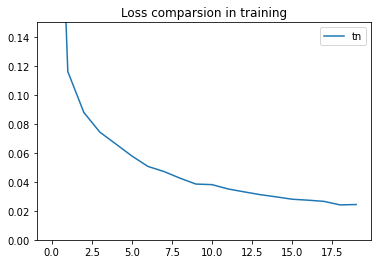

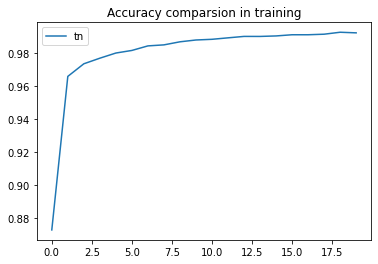

In [38]:
#loss = hist.history['loss']
#acc = hist.history['accuracy']
tn_loss = tn_hist.history['loss']
tn_acc = tn_hist.history['accuracy']

#plt.plot(loss, label='traditional')
plt.plot(tn_loss, label='tn')
plt.title('Loss comparsion in training')
plt.ylim(0, 0.15)
plt.legend()
plt.show()

#plt.plot(acc, label='traditional')
plt.plot(tn_acc, label='tn')
plt.title('Accuracy comparsion in training')
plt.legend()
plt.show()